In [1]:
import yfinance
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
plt.rcParams['figure.figsize'] = (18,6)
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.titlesize'] = 14 
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16

In [3]:
ltc = pd.read_csv('data/ltc-usd.csv', header=0, usecols=['timestamp','close'], parse_dates=['timestamp'], index_col=['timestamp'])


ltc = ltc.rename(columns={'close': 'price'})
ltc.head()

,price
timestamp,
2013-10-24,3.0
2013-10-25,3.0
2013-10-26,3.0
2013-10-27,3.0
2013-10-28,3.0


In [4]:
ltc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2013-10-24 to 2020-06-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2416 non-null   float64
dtypes: float64(1)
memory usage: 37.8 KB


In [5]:
ltc.describe()

,price
count,2416.000000
mean,40.118963
std,51.529457
min,1.200000
25%,3.821500
50%,17.765000
75%,57.535000
max,353.650000


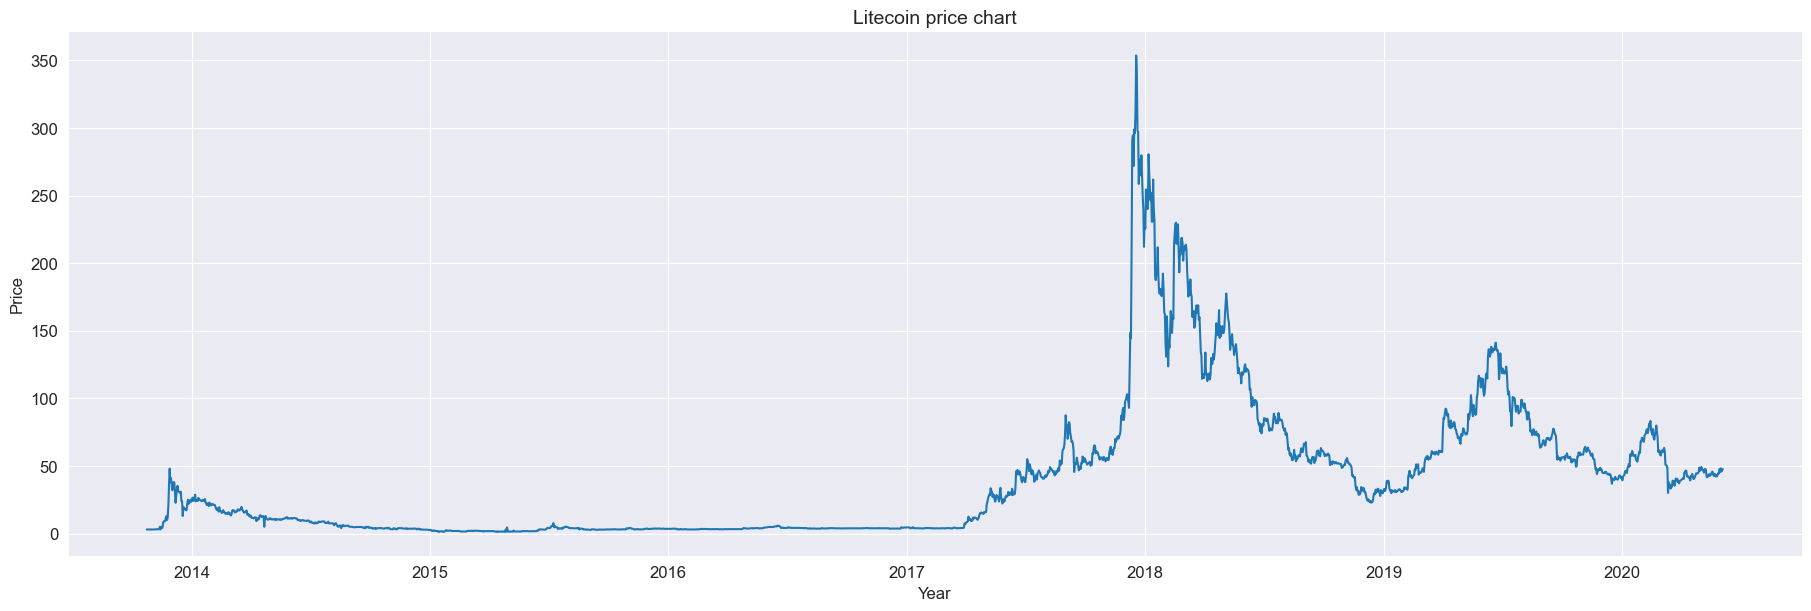

In [7]:
fig, ax = plt.subplots(constrained_layout=True)
plt.title('Litecoin price chart')
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(ltc)
ax.set_xlabel('Year')
ax.set_ylabel('Price') 
plt.show()

In [8]:
rolling_mean = ltc.rolling(window = 12).mean()
rolling_std = ltc.rolling(window = 12).std()
print(rolling_mean,rolling_std)

                price
timestamp            
2013-10-24        NaN
2013-10-25        NaN
2013-10-26        NaN
2013-10-27        NaN
2013-10-28        NaN
...               ...
2020-05-31  44.046667
2020-06-01  44.385833
2020-06-02  44.658333
2020-06-03  44.905833
2020-06-04  45.219167

[2416 rows x 1 columns]                price
timestamp           
2013-10-24       NaN
2013-10-25       NaN
2013-10-26       NaN
2013-10-27       NaN
2013-10-28       NaN
...              ...
2020-05-31  1.556204
2020-06-01  1.975056
2020-06-02  1.940576
2020-06-03  2.054509
2020-06-04  2.164295

[2416 rows x 1 columns]


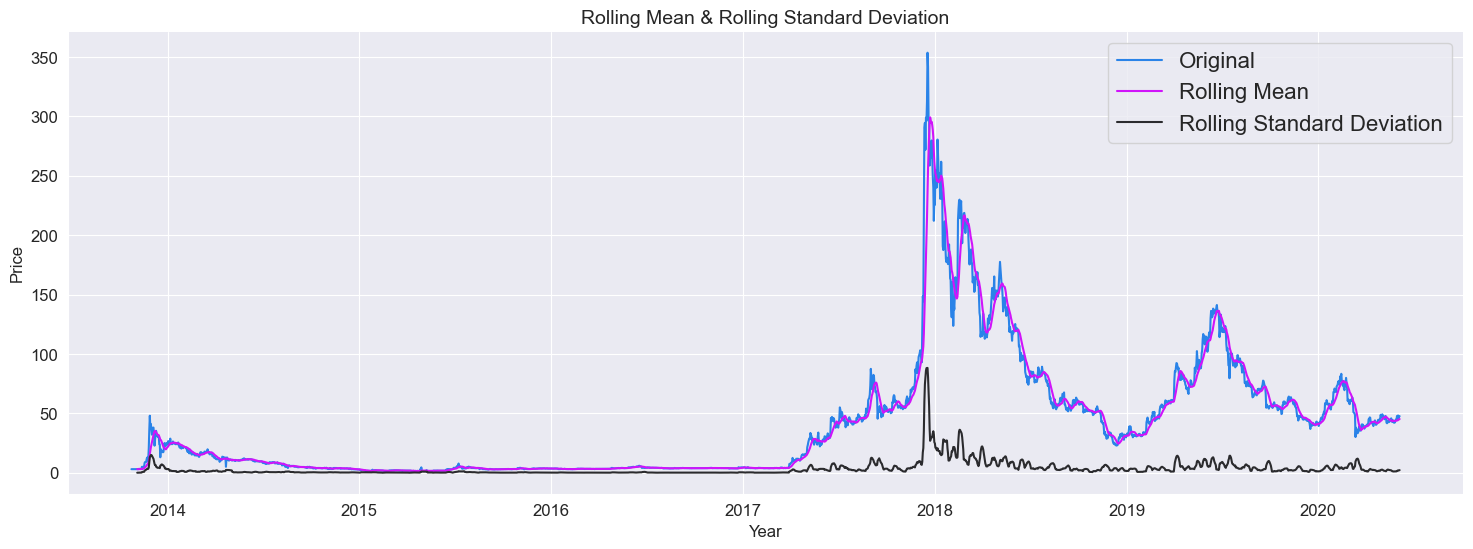

In [9]:
plt.plot(ltc, color = '#2a83e8', label = 'Original')
plt.plot(rolling_mean, color = '#d014fa', label = 'Rolling Mean')
plt.plot(rolling_std, color = '#2b2b2e', label = 'Rolling Standard Deviation')
plt.legend(loc = 'best')
plt.xlabel('Year')
plt.ylabel('Price') 
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [10]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
result = adfuller(ltc['price'], autolag='AIC')
result_output = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items():
    result_output['Critical Value (%s)'%key] = value    
print(result_output)

Results of Dickey Fuller Test:
Test Statistic                   -2.797292
p-value                           0.058662
#Lags Used                       26.000000
Number of Observations Used    2389.000000
Critical Value (1%)              -3.433090
Critical Value (5%)              -2.862751
Critical Value (10%)             -2.567414
dtype: float64


The ADF statistics are far from critical and the p-value is greater than the threshold (0,05). Therefore, we can conclude that the time series is not stationary.



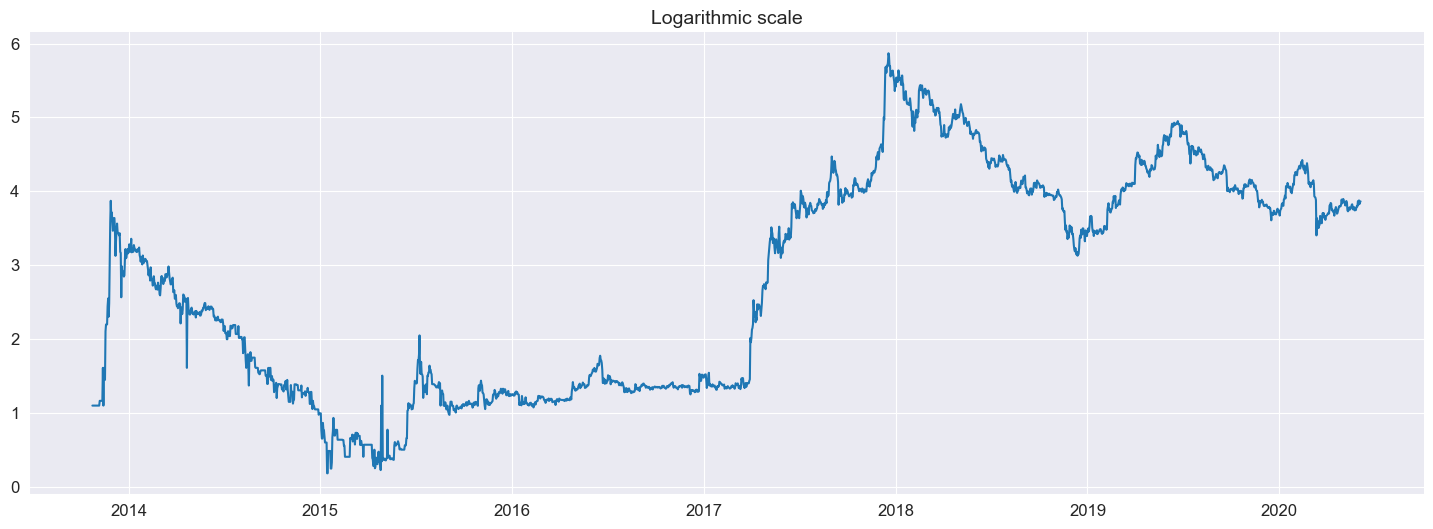

In [11]:
ltc_log = np.log(ltc)

plt.title('Logarithmic scale')
plt.plot(ltc_log)
plt.show()

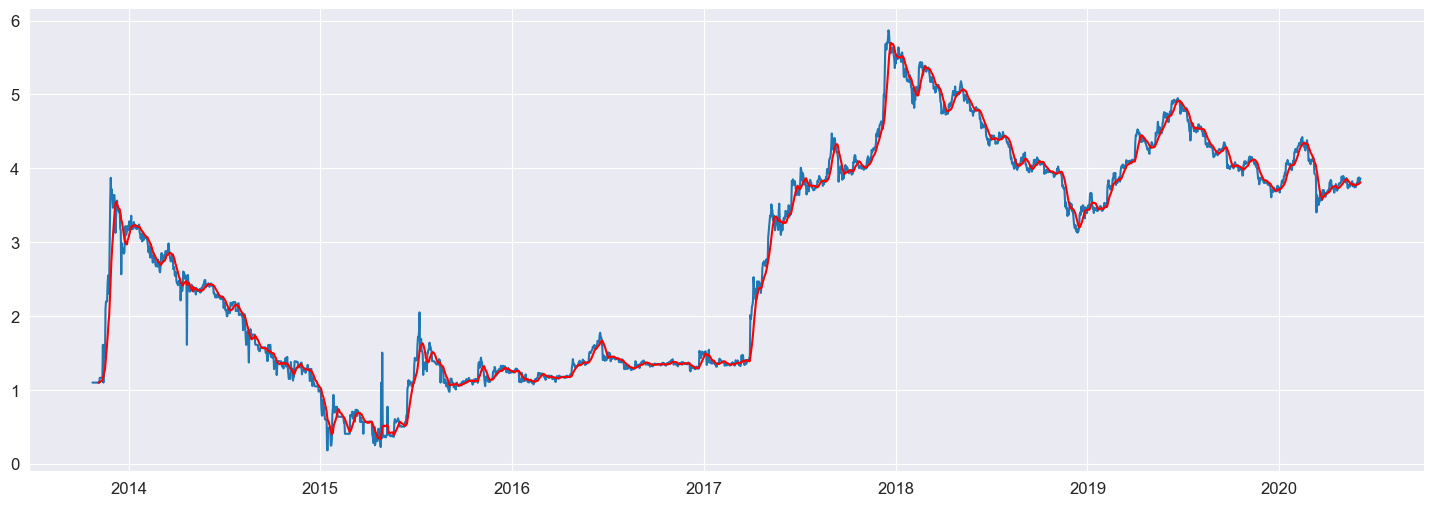

In [12]:
#The below transformation is required to make series stationary
movingAverage = ltc_log.rolling(window=12).mean()
movingSTD = ltc_log.rolling(window=12).std()
plt.plot(ltc_log)
plt.plot(movingAverage, color='red')
plt.show()

We will create a function that will run two tests that will determine whether a given time series is stationary.

In [13]:
ltcLogMinusMovingAverage = ltc_log - movingAverage
ltcLogMinusMovingAverage.head(12)

#Remove NAN values
ltcLogMinusMovingAverage.dropna(inplace=True)
ltcLogMinusMovingAverage.head(10)

,price
timestamp,
2013-11-04,0.000000
2013-11-05,0.000000
2013-11-06,0.000000
2013-11-07,0.059160
2013-11-08,0.053782
2013-11-09,0.048404
2013-11-10,0.043026
2013-11-11,0.037647
2013-11-12,0.032269


In [14]:
def test_stationarity(timeseries):
    
    # rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='#2a83e8', label='Original')
    mean = plt.plot(movingAverage, color='#d014fa', label='Rolling Mean')
    std = plt.plot(movingSTD, color='#2b2b2e', label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('\nResults of Dickey Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    result_output = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in result[4].items():
        result_output['Critical Value (%s)'%key] = value
    print(result_output)

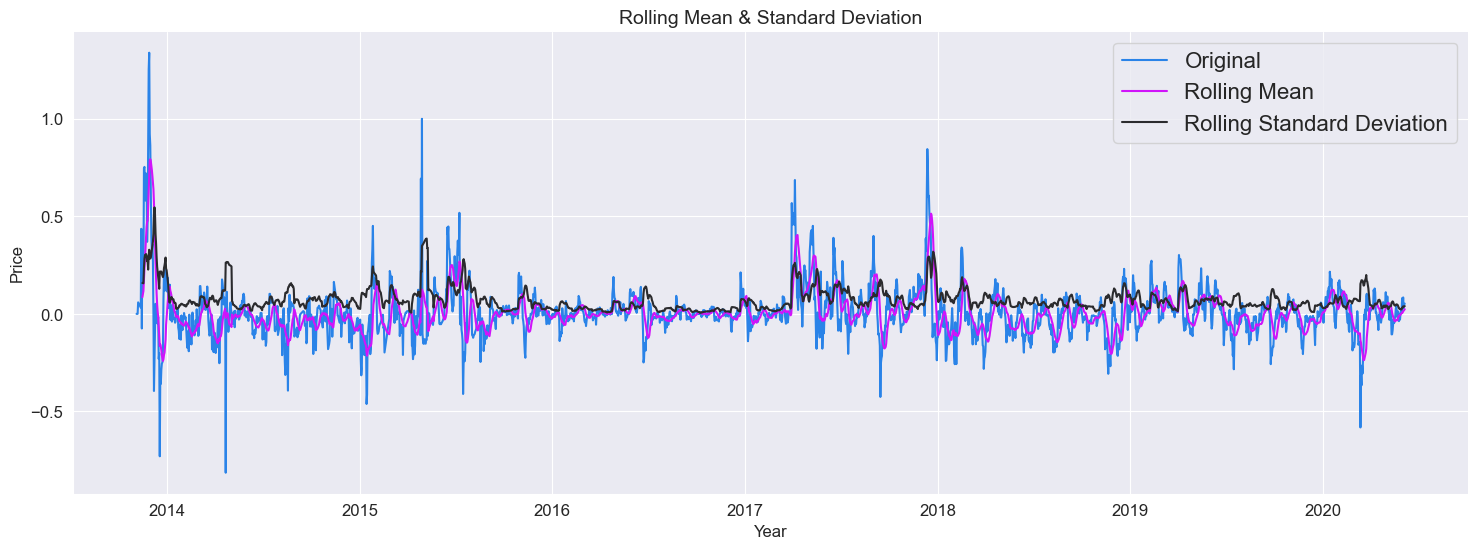


Results of Dickey Fuller Test:
Test Statistic                -1.004590e+01
p-value                        1.454771e-17
#Lags Used                     1.300000e+01
Number of Observations Used    2.391000e+03
Critical Value (1%)           -3.433088e+00
Critical Value (5%)           -2.862750e+00
Critical Value (10%)          -2.567414e+00
dtype: float64


In [15]:
test_stationarity(ltcLogMinusMovingAverage)

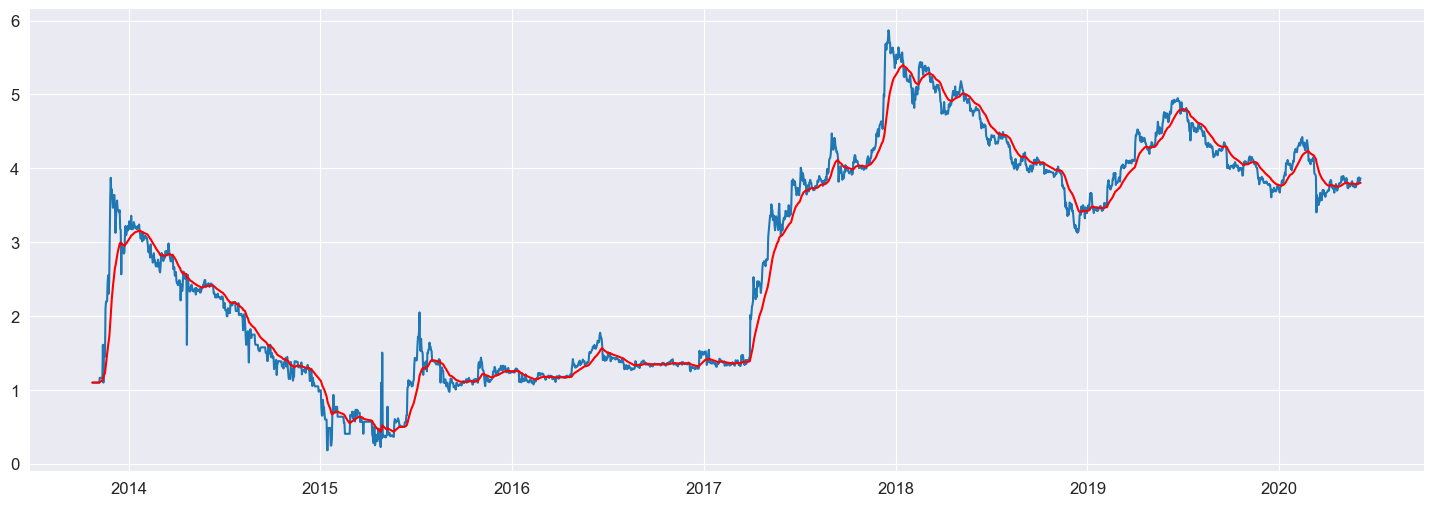

In [16]:
exponentialDecayWeightedAverage = ltc_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(ltc_log)
plt.plot(exponentialDecayWeightedAverage, color='red')
plt.show()

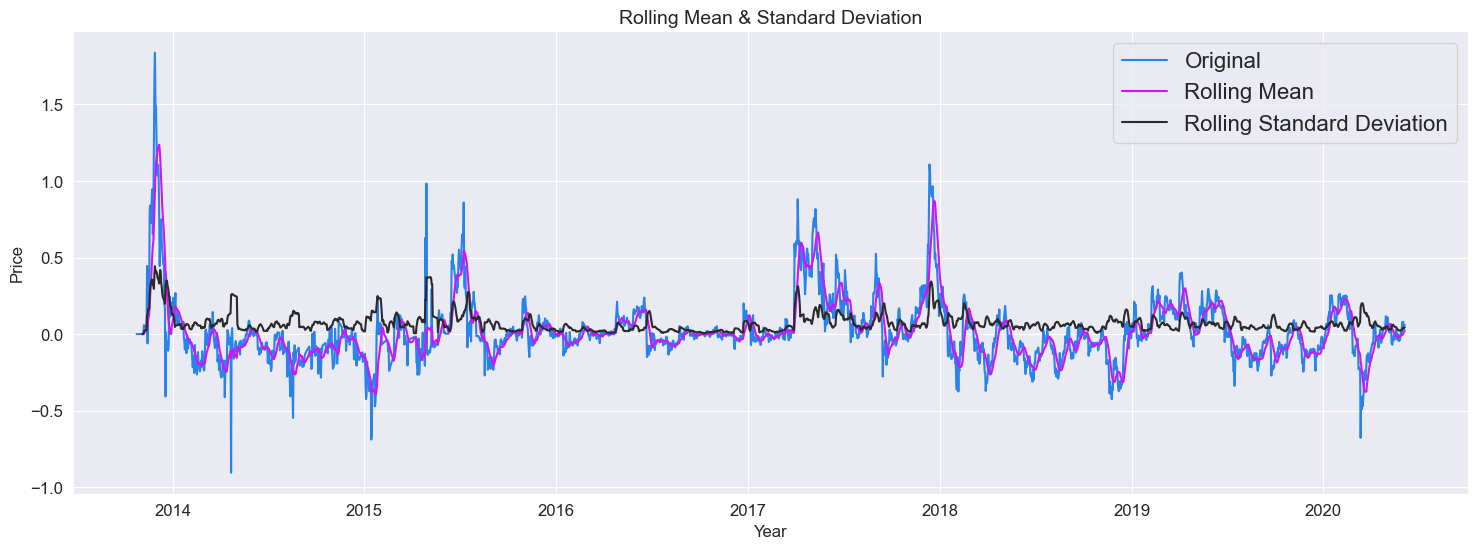


Results of Dickey Fuller Test:
Test Statistic                -7.108698e+00
p-value                        3.990985e-10
#Lags Used                     3.000000e+00
Number of Observations Used    2.412000e+03
Critical Value (1%)           -3.433064e+00
Critical Value (5%)           -2.862739e+00
Critical Value (10%)          -2.567408e+00
dtype: float64


In [17]:
ltcLogMinusExponentialMovingAverage = ltc_log - exponentialDecayWeightedAverage
test_stationarity(ltcLogMinusExponentialMovingAverage)

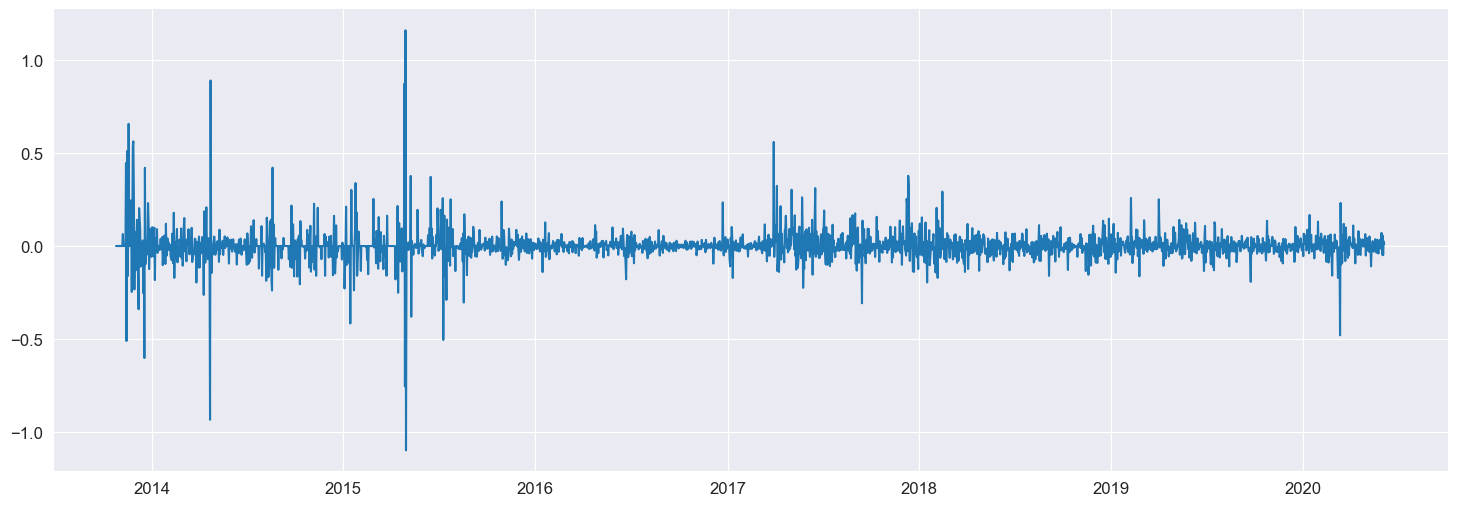

In [18]:
ltcLogDiffShifting = ltc_log - ltc_log.shift()
plt.plot(ltcLogDiffShifting)
plt.show()

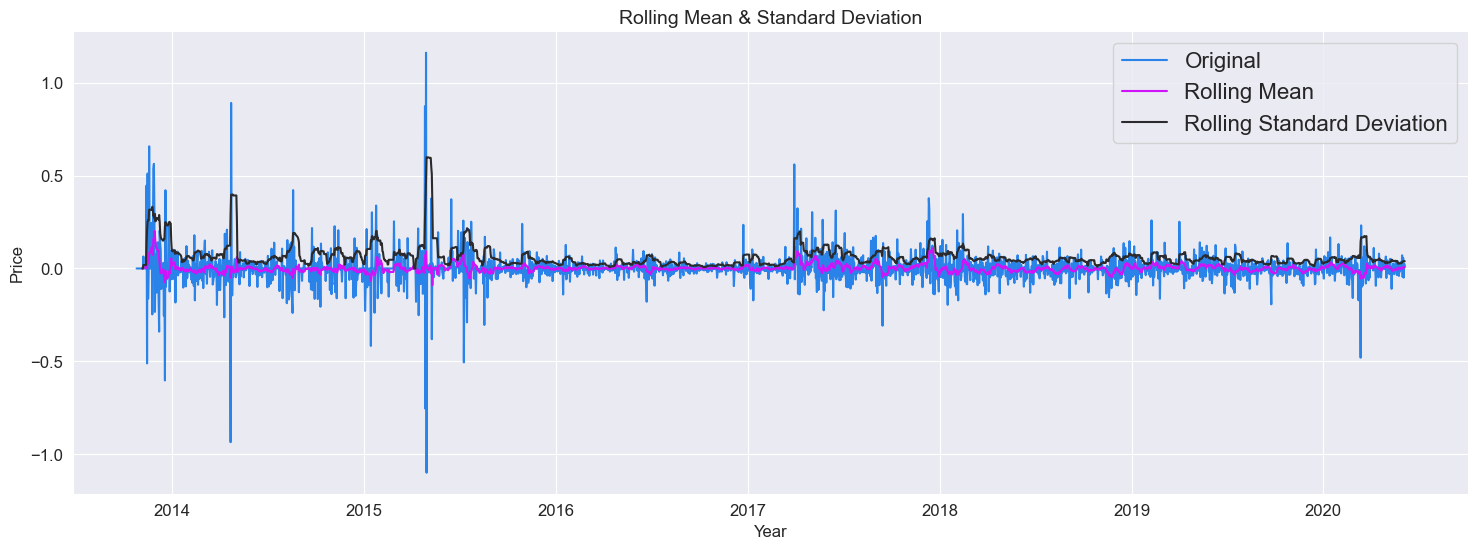


Results of Dickey Fuller Test:
Test Statistic                -1.459375e+01
p-value                        4.273180e-27
#Lags Used                     9.000000e+00
Number of Observations Used    2.405000e+03
Critical Value (1%)           -3.433072e+00
Critical Value (5%)           -2.862743e+00
Critical Value (10%)          -2.567410e+00
dtype: float64


In [19]:
ltcLogDiffShifting.dropna(inplace=True)
test_stationarity(ltcLogDiffShifting)

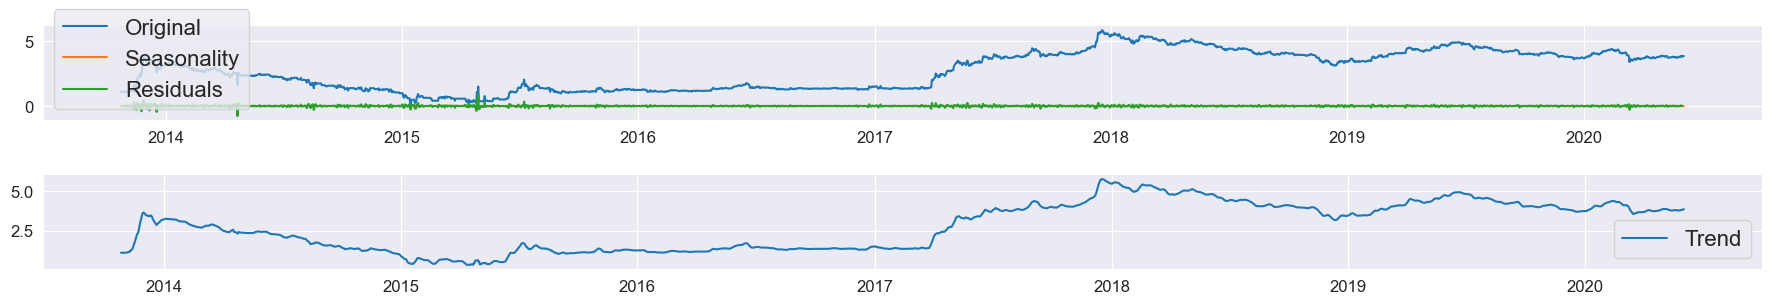

In [20]:
decomposition = seasonal_decompose(ltc_log) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ltc_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

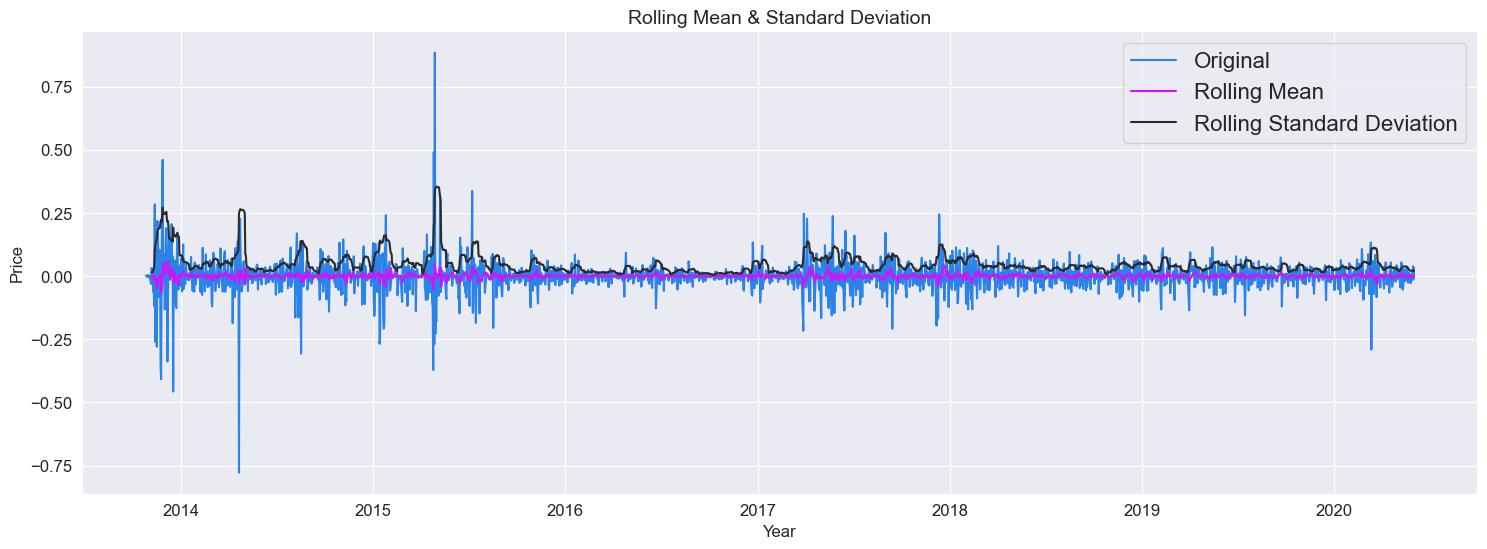


Results of Dickey Fuller Test:
Test Statistic                -1.657108e+01
p-value                        1.870034e-29
#Lags Used                     2.300000e+01
Number of Observations Used    2.386000e+03
Critical Value (1%)           -3.433094e+00
Critical Value (5%)           -2.862752e+00
Critical Value (10%)          -2.567415e+00
dtype: float64


In [21]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

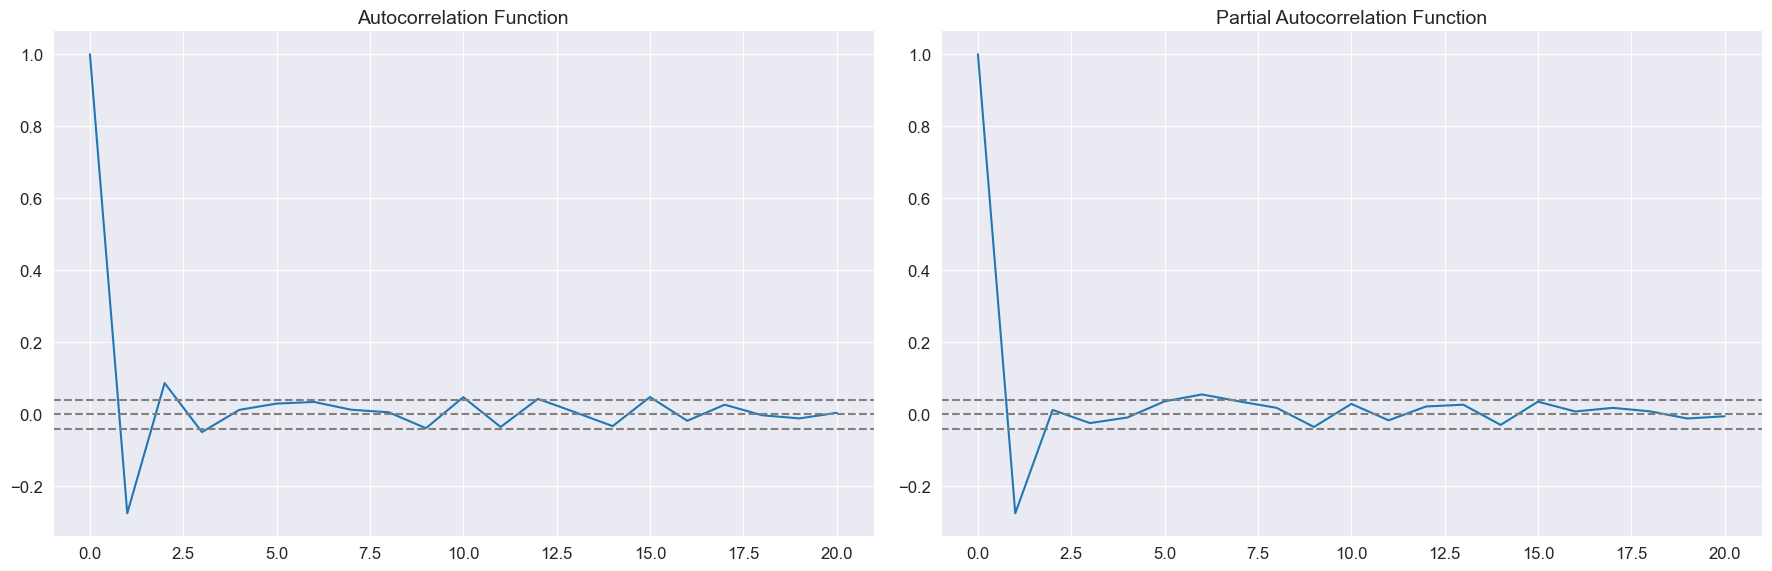

In [23]:
#ACF & PACF plots
lag_acf = acf(ltcLogDiffShifting, nlags=20)
lag_pacf = pacf(ltcLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ltcLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ltcLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ltcLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ltcLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

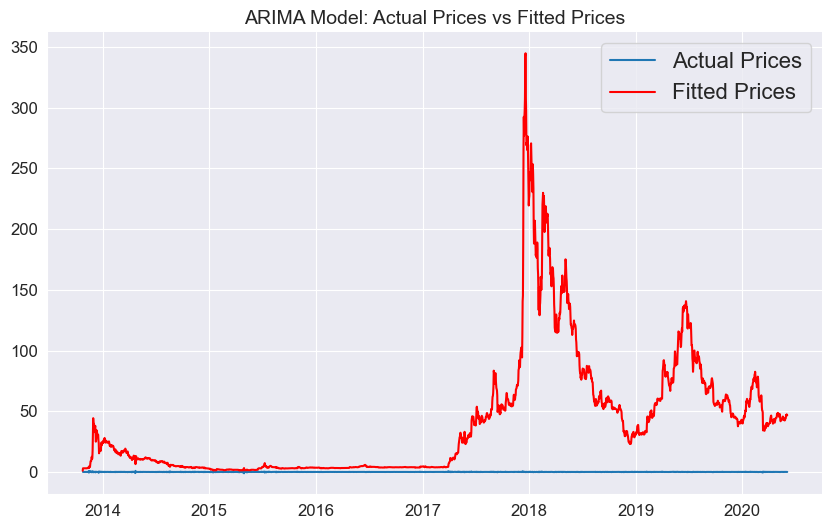

Residual Sum of Squares (RSS): nan


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pickle

# Fit the ARIMA model
model = ARIMA(ltc_log, order=(2, 1, 2))


results_AR = model.fit()

# Calculate the fitted values
fitted_values = results_AR.fittedvalues

# Convert the fitted values back to original scale (inverse log transform)
predicted_prices = np.exp(fitted_values)

# Plot the actual data and the fitted values
plt.figure(figsize=(10, 6))
plt.plot(ltcLogDiffShifting['price'], label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Fitted Prices')

plt.title('ARIMA Model: Actual Prices vs Fitted Prices')
plt.legend()
plt.show()

# Calculate the Residual Sum of Squares (RSS)
rss = sum((results_AR.fittedvalues - ltcLogDiffShifting['price'])**2)
print(f'Residual Sum of Squares (RSS): {rss:.4f}')
with open('ltc_arima_model.pkl', 'wb') as f:
    pickle.dump(results_AR, f)

In [28]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

timestamp
2013-10-24    0.000000
2013-10-25    1.098612
2013-10-26    1.098612
2013-10-27    1.098612
2013-10-28    1.098612
dtype: float64


In [29]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

timestamp
2013-10-24       0.000000
2013-10-25       1.098612
2013-10-26       2.197225
2013-10-27       3.295837
2013-10-28       4.394449
                 ...     
2020-05-31    6675.132279
2020-06-01    6678.965093
2020-06-02    6682.824672
2020-06-03    6686.666579
2020-06-04    6690.510641
Length: 2416, dtype: float64


In [30]:
predictions_ARIMA_log = pd.Series(ltc_log['price'].iloc[0], index=ltc_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

timestamp
2013-10-24    1.098612
2013-10-25    2.197225
2013-10-26    3.295837
2013-10-27    4.394449
2013-10-28    5.493061
dtype: float64

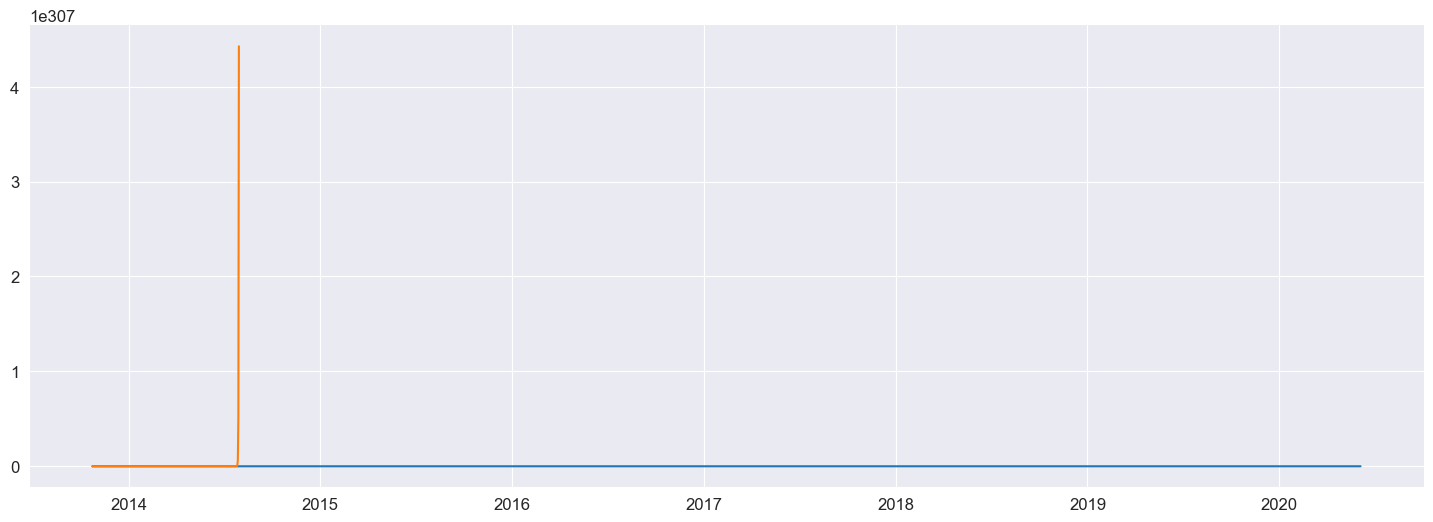

In [31]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ltc)
plt.plot(predictions_ARIMA)
plt.show()

In [32]:
ltc_log

,price
timestamp,
2013-10-24,1.098612
2013-10-25,1.098612
2013-10-26,1.098612
2013-10-27,1.098612
2013-10-28,1.098612
...,...
2020-05-31,3.819688
2020-06-01,3.876396
2020-06-02,3.827118
